In [1]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst
from src import visualization as viz
from src import cleaning

%matplotlib inline

# 1. Business understanding: let's discover the service online
We have worked on several datasets that contains a lot of data and we had a better understanding of the data we have in our hands.  
Now, the interesting part would be to link this data with the online service and make some relationships of what we have observed in data and what is displayed on the website.

## 1.1. Front page - Looking for an apartment
Here is the Airbnb listing page for Paris ![](../assets/airbnb_homepage_paris.png)  
There are a lot of informations we have already met in datasets on this single page:
* of course pictures for the listings
* listing type (in blue) and number of beds (in orange)
* listing name (in yellow)
* cost for 1 night (in € here) (in green) and so the cost for the whole duration
* a review rating (but not exactly the same as what we have seen, remember it was a note from 20 to 100) (in purple)
* I guess it is the number of rewiews for this listing (in grey)
* is the host a "superhost" ? (in red)

In [2]:
# Let's load the datasets
# df_lst = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0, low_memory=False)
# df_lst_sum = pd.read_csv(datacollector.get_data_file(cst.LISTING_LIGHT_FILE), sep=',', header=0, low_memory=False)
df_cal = pd.read_csv(datacollector.get_data_file(cst.CALENDAR_FILE), sep=',', header=0)
# df_reviews = pd.read_csv(datacollector.get_data_file(cst.REVIEWS_FILE), sep=',', header=0)

In [48]:
viz.get_hp_infos_for_listing(df_lst, 'Beautiful room & Hammam in a').head()

,id,name,room_type,beds,price,number_of_reviews,review_scores_rating,host_is_superhost
28758,17917735,Beautiful room & Hammam in a Hotel & Coworking,Private room,1.0,$119.00,233,96.0,t


We can confirm our intuitions:
* `room_type` is accurate, we are not renting a whole apartment but just a room within an hotel.
* there is only 1 bed as mentionned.
* for the `reviews`, 96/20=4.8 so it is accurate as well.
* host is really a "superhost"
* `price` is different but I will check on calendar dataset for this particular period
* `number of reviews` is different

In [49]:
# Price for this place at this period
df_cal[(df_cal['listing_id'] == 17917735) & (df_cal['date'] > '2019-08-05') & (df_cal['date'] < '2019-08-09')]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
10466611,17917735,2019-08-06,t,$109.00,$109.00,1.0,7.0
10466612,17917735,2019-08-07,f,$109.00,$109.00,1.0,7.0
10466613,17917735,2019-08-08,t,$109.00,$109.00,1.0,7.0


In [51]:
# Check the number of reviews
df_reviews[df_reviews['listing_id'] == 17917735].id.count()

233

***Note:*** price was effectively lower for this period of time and I guess that, as it has not been rented, the hotel made again a discount (from 109€ to 90). The number of reviews is consistent among datasets so maybe the host got 22 more reviews between the day data has been collected and the day I went on the website.

## 1.2. Having a better understanding of price management
If you well remember we have seen that in `calendar` dataset there are 2 different `prices` possible: `price` and `adjusted_price`. Let's try to understand that with a real sample.

In [52]:
df_cal[df_cal['price'] != df_cal['adjusted_price']].head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6746,57766,2019-07-11,t,$650.00,$605.00,6.0,60.0
6747,57766,2019-07-12,f,$650.00,$605.00,6.0,60.0
6748,57766,2019-07-13,f,$650.00,$605.00,6.0,60.0
6749,57766,2019-07-14,f,$650.00,$605.00,6.0,60.0
37965,77482,2019-07-11,f,$600.00,$570.00,2.0,365.0


Let's take the second listing for which the difference is exactly 5% discount. Let's go on the website for this listing:  
<img src='../assets/airbnb_listing_77482.png' width='550'>  
We can see that the **price is 570€**. It is written in french but it says that this host can even do 10% discount if you rent for the whole month.

## 1.3. Let's see the reviews
Still with this listing with id 77482, let's have a look at the reviews online and within the dataset. Here are the given notes online (in early August 2019):  
<img src='../assets/airbnb_reviews_77482.png' width='550'>  

In [65]:
print("There are {} rewiews for this listing !".format(df_reviews[df_reviews['listing_id'] == 77482].id.count()))

There are 435 rewiews for this listing !


In [66]:
print("The last review has been made on {} for this listing.".format(df_lst[df_lst['id'] == 77482].last_review.tolist()[0]))

The last review has been made on 2019-07-04 for this listing.


This is strange: the website says only 100 reviews but we have more than 400 in the `reviews` dataset. The last one displayed is from December 2018, let's count until this date if possible.

In [67]:
print("There are {} rewiews before 2018, Dec the 31st for this listing !".format(df_reviews[(df_reviews['listing_id'] == 77482) & (df_reviews['date'] < '2018-12-31')].id.count()))

There are 325 rewiews before 2018, Dec the 31st for this listing !


Still not, this is really weird. And let's see the ratings:

In [63]:
df_lst[df_lst['id'] == 77482][['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
153,98.0,9.0,9.0,9.0,10.0,9.0,9.0


---
# 2. Use case proposal
Based on what we have seen in the data and what is shown on the website, here is the scenario I imagine:  
I will put myself in the shoes of a tourist who would love to come and visit Paris !

> As a tourist/foreigner and a user of Airbnb service and as I absolutely do not know Paris, I would like to know what is the best period or the best place (or both) in order to plan my visit/holidays. 

> I would like to have a pretty good idea of the cost variation depending on location place and the dates and, obviously, I would be glad to know what are the odds to find something available for a given period so that perhaps I can adapt my holidays accordingly to places availabilities (there is an alternative for the homeowner who would like be sure to rent at the best time that will maximize the profit and so maybe adapt the location availability depending on the market as well).

> BONUS: is it possible to find representative themes per places so that the service can help me and guide me in my choice (perhaps by asking me few questions) ?

Some questions may be answered by analyzing data and providing graph plots. For the **price prediction**, I will try to find whether it is possible to predict price and if yes **what are the most important elements that play a role in its value**.  
So that, still with the "questioning the service user" scenario, we can give a pretty accurate estimation of the cost.

***Does the place matter ? And what about the number of beds available ? Or perhaps it is just something else you are not even thinking about...***

---
# 3. Insights
## 3.1. Choosing the right place
As a reminder, here is the graph of Paris neighbourhoods:

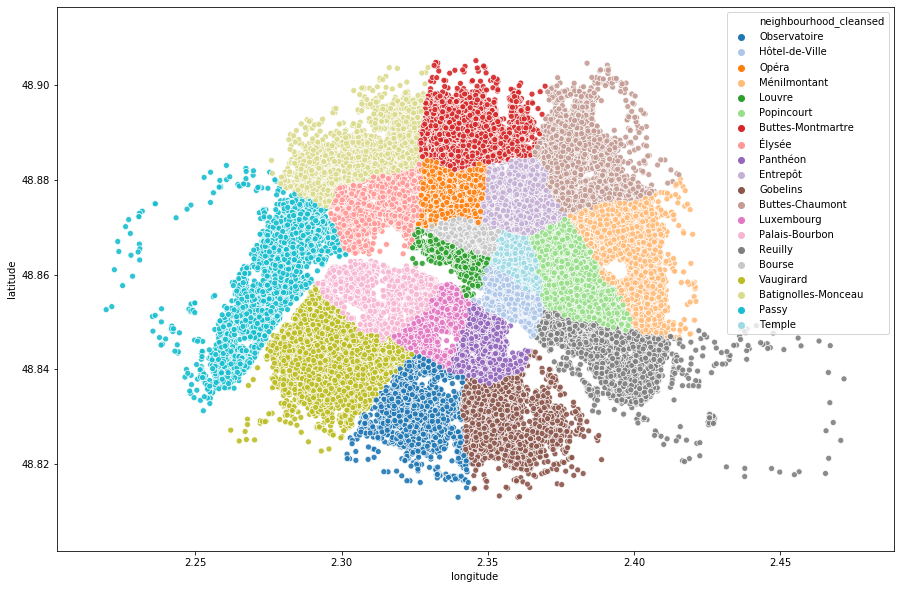

In [70]:
figure, axis = plt.subplots(1, 1, figsize=(15, 10))
sns.scatterplot(x="longitude", y="latitude", hue="neighbourhood_cleansed", data=df_lst, alpha=0.9, palette="tab20", ax=axis)
plt.show()

It is written in this [french study](https://edito.seloger.com/actualites/barometre-lpi-seloger/paris-quel-prix-immobilier-dans-votre-arrondissement-article-31984.html) published in April 2019 that _"the price of real estate has reached stratospheric levels and totally disconnected from residents' incomes. But what are the prices, neighbourhood per neighbourhood ?"_  
And it comes with an image displaying the mean price in euros per square meter if you would like to buy in Paris. Here it is:  
<img src='../assets/prix_immobilier_arrondissement_paris_avril.jpg' width="650">  

Top 5 is:
1. 6e (Luxembourg) (13 944 €/ m²)
2. 7e (Palais-Bourbon) (13 569 €/ m²)
3. 4e (Hôtel-de-Ville) (13 262 €/ m²)
4. 8e (Elysée) (12 436 €/ m²)
5. 16e (Passy) (11 753 €/ m²)

19e and 20e (respectively Buttes-Chaumont and Ménilmontant) have the "cheapest" price according to this study.

**Is it something that we can also observe in our dataset ?**

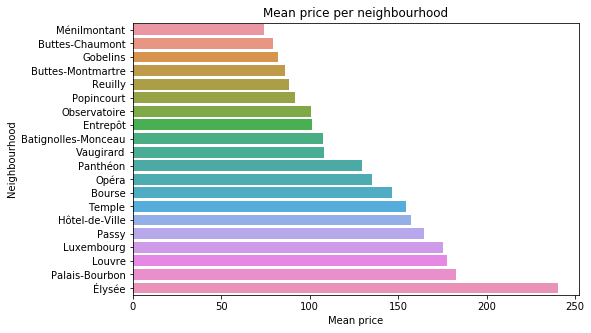

In [79]:
figure, axis = plt.subplots(1, 1, figsize=(8, 5))
sns.barplot(y="neighbourhood", x='price', data=df_lst_sum.groupby('neighbourhood')['price'].mean().reset_index().sort_values(by='price'), ax=axis)
axis.set_title("Mean price per neighbourhood")
axis.set_xlabel("Mean price")
axis.set_ylabel("Neighbourhood")
plt.show()

***Interesting: the top 5 from the study is within the top 6 of the mean price !***  
Let's take neighbourhood as a pivot value and check the impact on other features such as the availability or even the reviews:

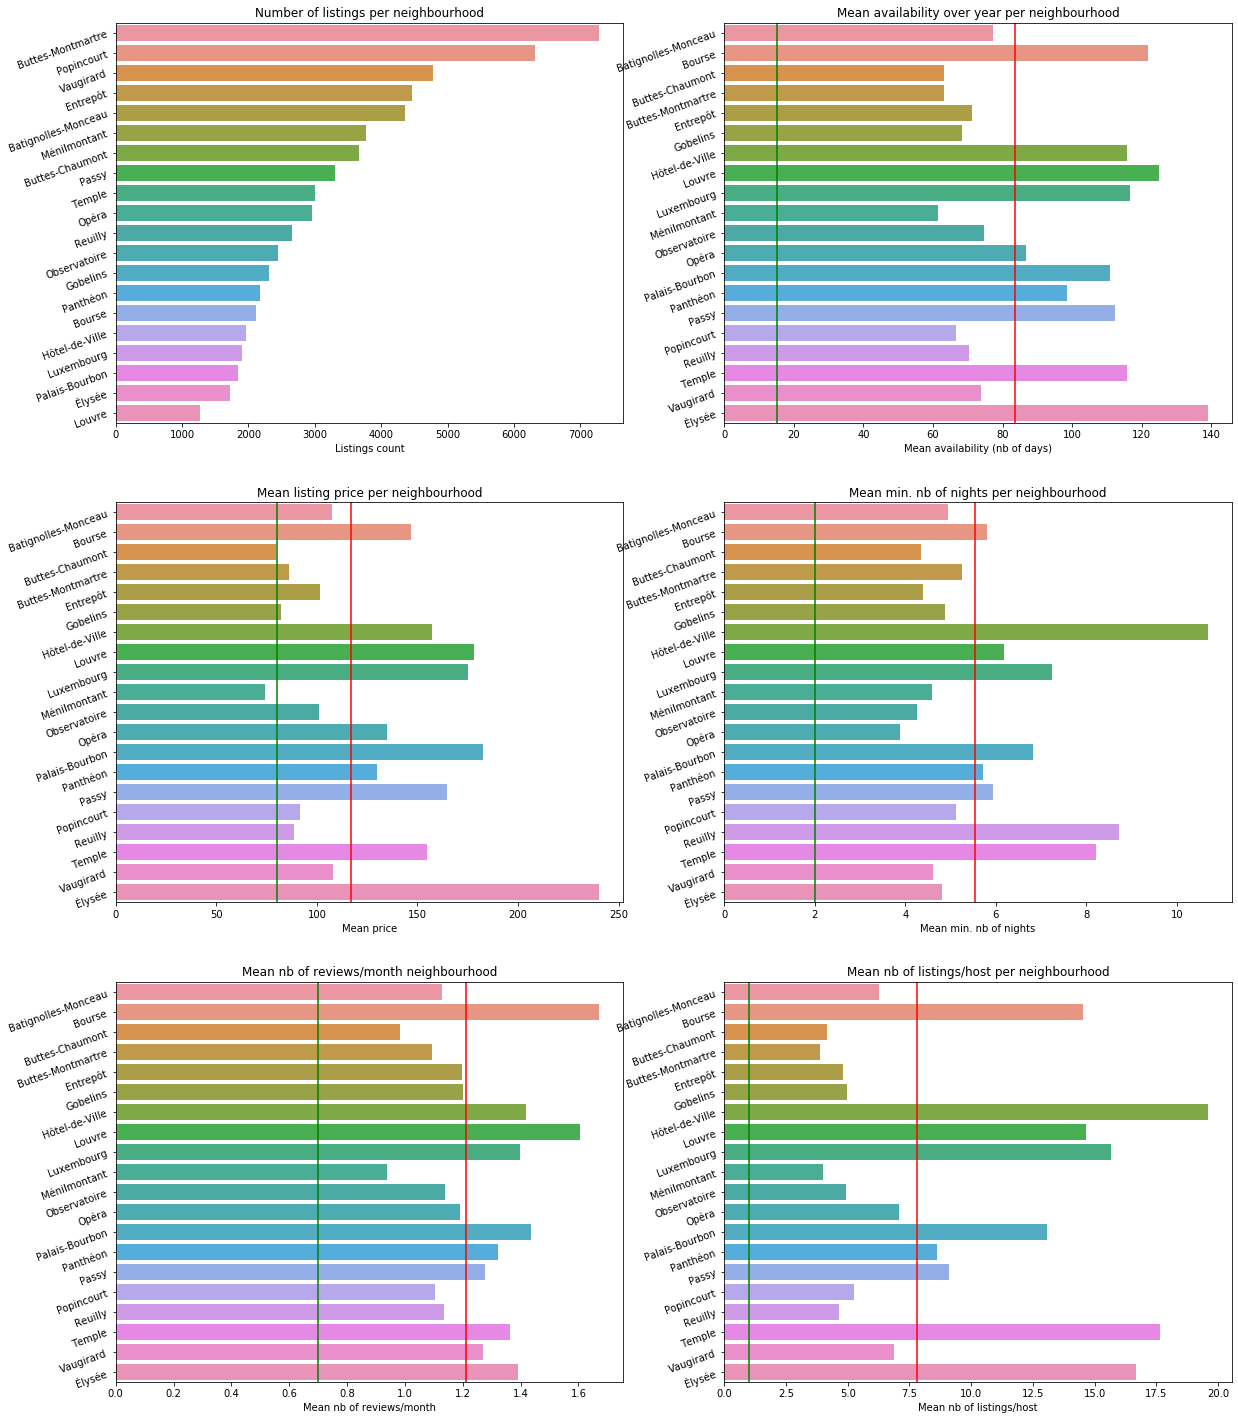

In [22]:
viz.plot_listings_summary_neighbourhood(df_lst_sum)
# Note: in plots below, the green line is for the median, red line is for the mean

***Observations:***
* The **number of listing is unbalanced** and depending on what we will do later, this could be an issue to deal with.
* **_'Elysée'_ is far the most expensive neighbourhood** and the one **with most availability** (perhaps due to the price ?) even if there are few listings (only _'Louvre'_ has less listings to offer).
* 10 neighbourhoods have mean price above the mean value (116, represented by red horizontal line in the last plot) while 10 have mean price below.
* It is though important to notice that only **2 neighbourhoods have mean price below the median value** (80, represented by horizontal green line in last plot): _'Ménilmontant'_ and _'Buttes-Chaumont'_. This is not really a surprise for one who knows Paris are those 2 neighbourhoods are the "less" expensive one. They provide a good number of listings but with few availability per year, 60 days in average.
* There are **3 neighbourhoods** (_'Hotel-de-Ville'_ for example) for which the **minimum number of nights** if you want to stay is **quite high (more than 1 week)**. So if you plan to stay only for few days, some of them are not for you but if you plan to stay longer, it is possible within those neighbourhoods.
* _'Louvre'_ and _'Bourse'_ are the neighbourhoods with the highest number of reviews per month, meaning that if they have a review, it is probably because it has been rented. But this is perhaps not really significant as we have also seen that those 2 neighbourhoods are in the top 3 for availability over a year (even if there are few listings).

### It depends on what kind of room you are looking for...
We have seen that there are 3 types of room:
* Entire home/apt
* Private room
* Shared room

What is the share ? Where are they ? Does it change something on the price ?

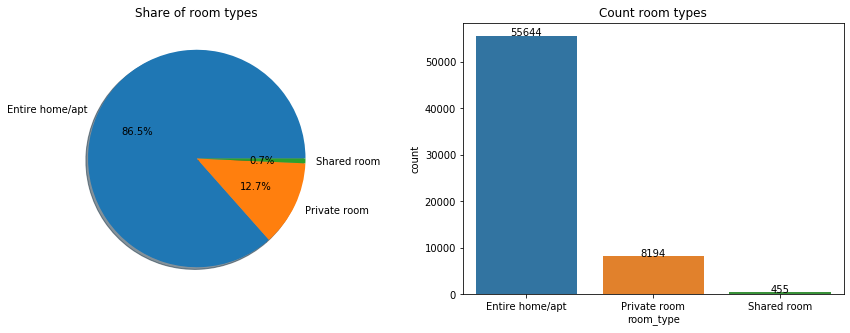

In [85]:
viz.plot_room_type_share(df_lst_sum)

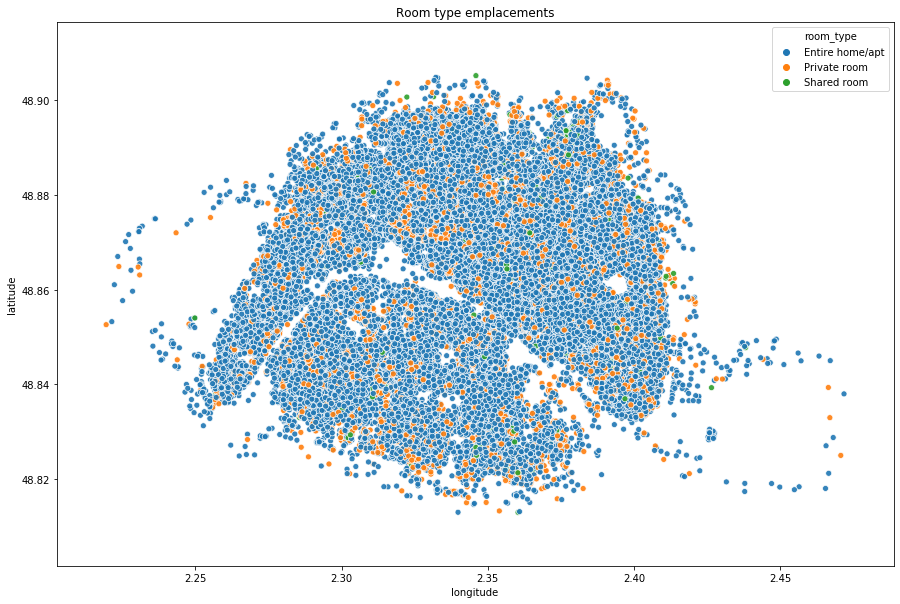

In [4]:
viz.plot_room_type_places(df_lst_sum)

Due to the huge number of apartments vs. rooms, this was expected. **There are rooms almost everywhere so choosing apartment or room will not force you to go at a particular place. Good point.**

Let's now check if choosing one or the other has an impact on the price:

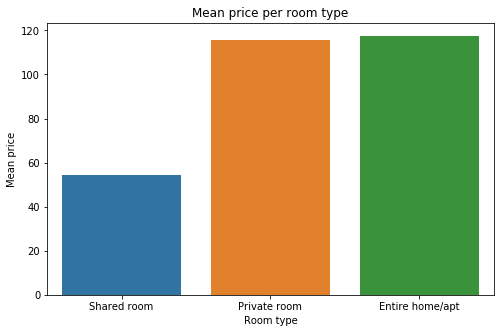

In [5]:
viz.plot_room_type_mean_price(df_lst_sum)

This is interesting also ! It seems that **choosing a private room or an entire apartment has few influence on the price**. On the other side, **you can expect to divide by 2 the mean price by choosing a shared room**. But you will probably be with other guests, that is obvious. There are less than 500 shared rooms available but they are almost everywhere. So, ready to share your room ?

### Where are the most and less expensive listings ?
We have seen that shared rooms are less expensive so I will filter them to not catch them in the less expensive listings.

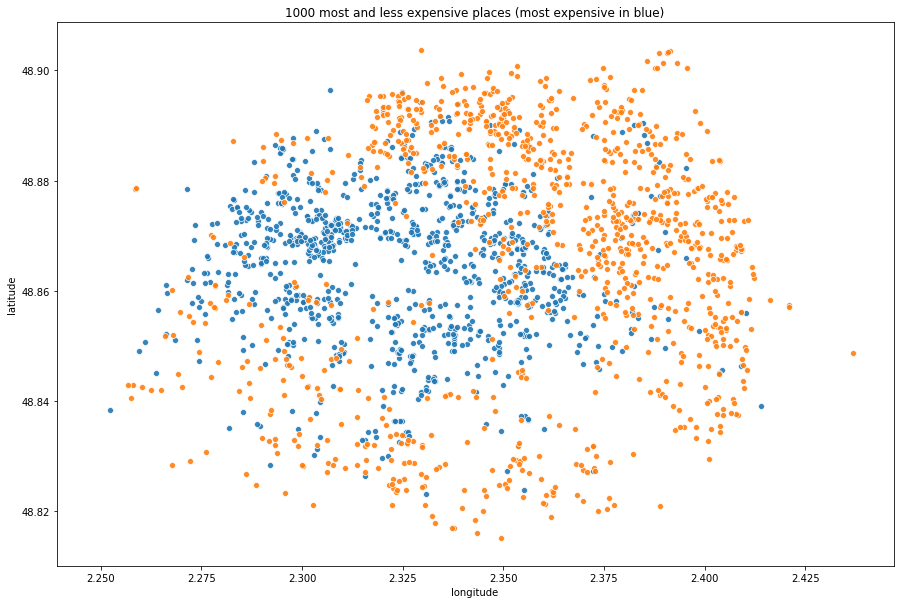

In [3]:
viz.plot_top_flop_expensive_places(df_lst_sum)

***Conclusion:*** depending on your budget, it can really cost you a lot to sleep in Paris. The most expensive neighbourhoods are the one in the center of the city, you will pay less and less gradually as you go further but in those neighbourhoods, the availability rate is not very high. You will find apartments in which people live most of the time and rent when they are away from their home.  
_Tip:_ you can expect to divide by 2 the mean price by choosing a shared room and there are almost everywhere in the city so that you are not stuck in a specific place.

## 3.2. Choosing the right time
### Are there some periods of time with higher/lower availabilty ?

In [3]:
# Calendar transformations
df_cal = cleaning.transform_t_f(df_cal, 'available')
df_cal = cleaning.calendar_clean_price(df_cal)

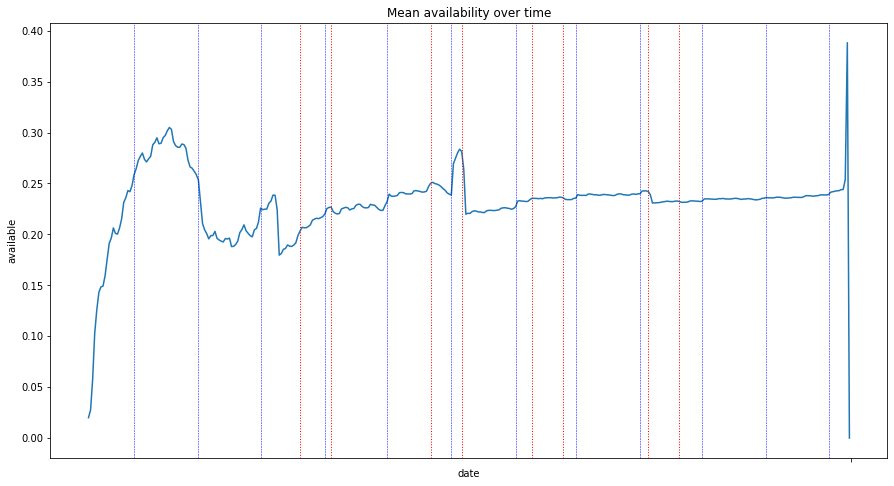

In [40]:
# Each vertical blue line marks the end of a month
# School holidays are represented by 2 vertical red lines: one for the beginning, one for the end
viz.plot_something_over_time(df_cal, 'available')

We can split this graph into several periods:
* the availability quickly is very low at the beginning (July) but I guess this behaviour is expected as most of the listings have found guests for the next coming weeks.
* there is a peak in august which is the highest availability. Again, this is summer holidays and I guess that a lot of people who are leaving somewhere else have put their home/apartment as available.
* we then see the 'Back to school' impact in september with another availability peak for autumn holidays.
* it then becomes more and more available with a new availability peak just after Christmas holidays, for New Year (want to see fireworks at Eiffel Tower ?).
* after that it goes back to "normal" and flat rate.

**Note:** it seems that school holidays (small bins between red lines have not really a big impact).

### Variation of price over time

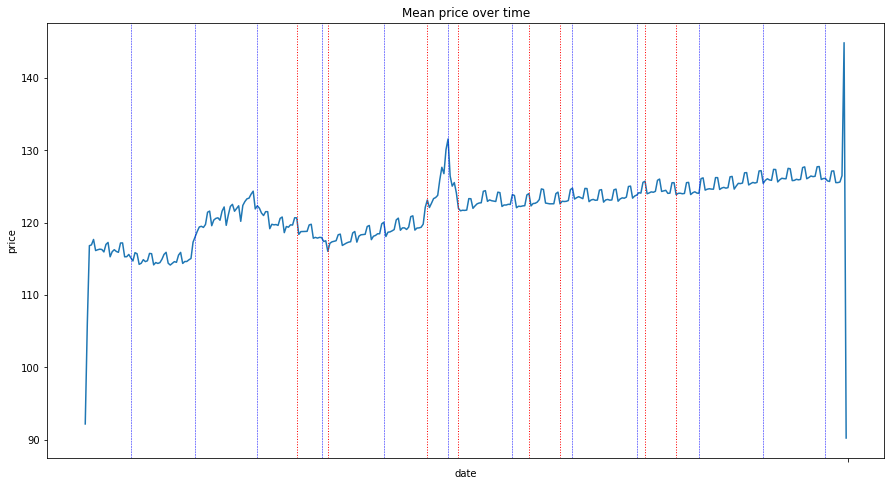

In [42]:
viz.plot_something_over_time(df_cal, 'price')

***Observations:***
* it is typically the law of supply and demand: **prices are lower in August** (because there are a lot of rooms to share and home owners prefer doing discount than nothing)
* there is a **peak during Christmas holidays** so even if there are more apartments available, **you will spend more money if you plan coming for New Year fireworks at Eiffel Tower**.
* the "small" and recurrent peaks corresponds to weekends. **Prices are higher during the weekends**. There are no small savings.

### Impact of neighbourhood on availability and price over time

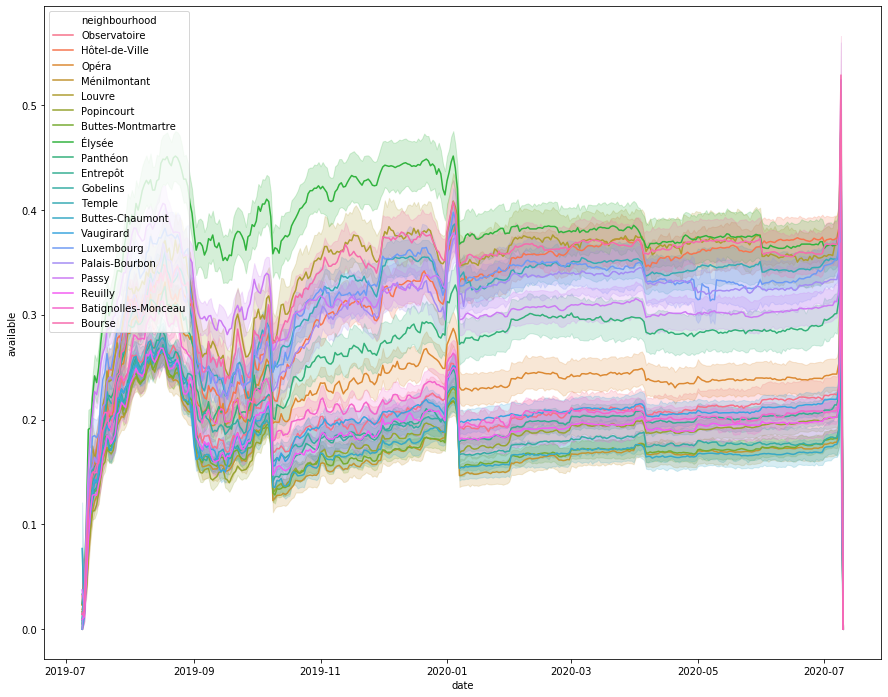

In [17]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date", y="available", hue="neighbourhood", data=df_merged[['date', 'available', 'neighbourhood']])
plt.show()

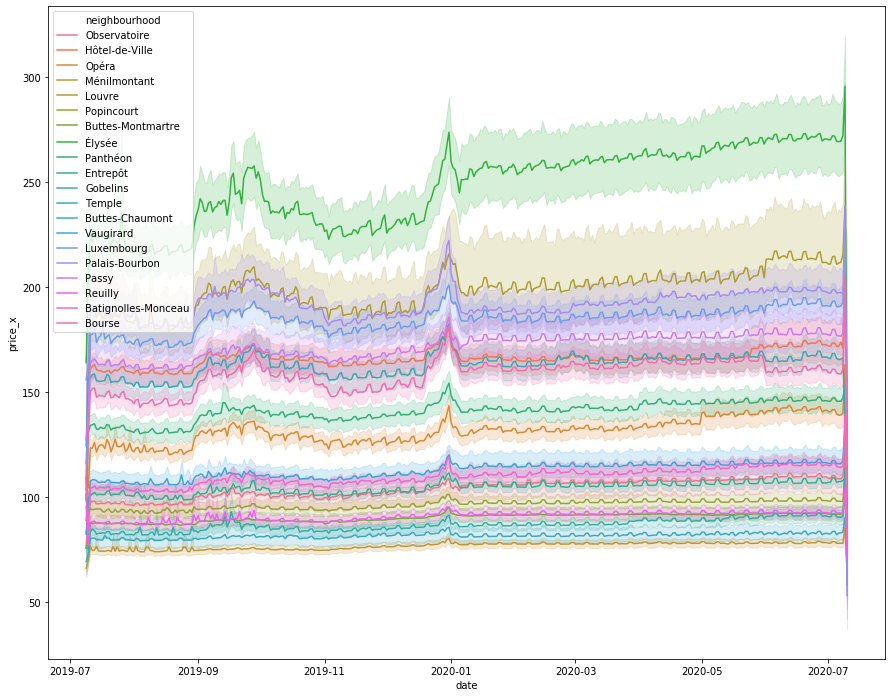

In [26]:
figure, axis = plt.subplots(1, 1, figsize=(15, 12))
sns.lineplot(x="date",y="price_x", hue="neighbourhood", data=df_merged)
plt.show()
# ça ne fait qu'augmenter à partir de janvier, de + en + cher à l'approche de l'été
# on observe des pics réguliers sur les courbes (hausse sur le WE chaque semaine => plotter plus fin pour vérifier)
# comprendre aussi ce que signifie la variance pastel sur les courbes


### When are the most and less expensive listings available ?

---
## Merging calendar + listings

In [9]:
df_merged = pd.merge(df_cal, df_lsts, how='left', left_on='listing_id', right_on='id')
df_merged.drop('listing_id', axis=1, inplace=True)

In [10]:
df_merged.shape

(23467355, 22)

In [11]:
df_merged.head()

,date,available,price_x,adjusted_price,minimum_nights_x,maximum_nights,id,name,host_id,host_name,...,latitude,longitude,room_type,price_y,minimum_nights_y,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2019-07-10,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
1,2019-07-11,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
2,2019-07-12,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
3,2019-07-13,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
4,2019-07-14,f,$75.00,$75.00,3.0,15.0,3109,zen and calm,3631,Anne,...,48.83349,2.31852,Entire home/apt,60,3,8,2018-12-19,0.26,1,227
